# Can QML Beat Classical ML? A Fair Comparison

**Goal**: Compare quantum and classical ML models on small real-world datasets where QML has a fair chance. We test on multiple datasets with the same sample sizes to make a fair comparison.

**Key Question**: Can quantum machine learning outperform classical ML on these tasks?

**Datasets**: Small real-world datasets (Iris, Wine, Breast Cancer) where we can use full data without extreme dimensionality reduction.


# Imports


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA

# Quantum imports
from qiskit.circuit.library import ZZFeatureMap
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector


# Load Small Real-World Datasets


In [ ]:
def load_all_datasets():
    """Load multiple small real-world datasets."""
    datasets = {}
    
    # Iris dataset (3 classes, 4 features) - convert to binary
    iris = load_iris()
    X_iris = iris.data
    y_iris = iris.target
    # Use only first 2 classes for binary classification
    mask = y_iris < 2
    datasets['Iris'] = (X_iris[mask], y_iris[mask])
    
    # Wine dataset (3 classes, 13 features) - convert to binary
    wine = load_wine()
    X_wine = wine.data
    y_wine = wine.target
    # Use only first 2 classes
    mask = y_wine < 2
    datasets['Wine'] = (X_wine[mask], y_wine[mask])
    
    # Breast Cancer dataset (2 classes, 30 features)
    cancer = load_breast_cancer()
    datasets['BreastCancer'] = (cancer.data, cancer.target)
    
    return datasets

datasets = load_all_datasets()

print("Dataset Summary:")
for name, (X, y) in datasets.items():
    print(f"{name}: {X.shape[0]} samples, {X.shape[1]} features, {len(np.unique(y))} classes")


In [ ]:
# Reduce to 2D for Quantum Compatibility
# Since quantum feature maps work best with 2 qubits (2 features), we'll reduce all datasets to 2D using PCA.
# This is still a limitation, but we'll compare classical models on both full-dimensional and 2D data.

def reduce_to_2d(X_train, X_test, random_state=42):
    """Reduce features to 2D using PCA."""
    pca = PCA(n_components=2, random_state=random_state)
    X_train_2d = pca.fit_transform(X_train)
    X_test_2d = pca.transform(X_test)
    explained_var = pca.explained_variance_ratio_.sum()
    return X_train_2d, X_test_2d, explained_var

# Prepare datasets with train/test splits
prepared_datasets = {}
for name, (X, y) in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Scale full-dimensional data
    scaler_full = StandardScaler()
    X_train_full = scaler_full.fit_transform(X_train)
    X_test_full = scaler_full.transform(X_test)
    
    # Reduce to 2D and scale
    X_train_2d, X_test_2d, explained_var = reduce_to_2d(X_train, X_test)
    scaler_2d = StandardScaler()
    X_train_2d_scaled = scaler_2d.fit_transform(X_train_2d)
    X_test_2d_scaled = scaler_2d.transform(X_test_2d)
    
    prepared_datasets[name] = {
        'X_train_full': X_train_full,
        'X_test_full': X_test_full,
        'X_train_2d': X_train_2d_scaled,
        'X_test_2d': X_test_2d_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'explained_var': explained_var
    }
    
    print(f"{name}: {X_train_full.shape[1]}D -> 2D (explained variance: {explained_var:.3f})")


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training set shape: (25000, 1000)
Test set shape: (25000, 1000)
Training labels distribution: [12500 12500]
Test labels distribution: [12500 12500]


# Visualize 2D Projections


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, data) in enumerate(prepared_datasets.items()):
    ax = axes[idx]
    X_train_2d = data['X_train_2d']
    y_train = data['y_train']
    
    for class_label in np.unique(y_train):
        mask = y_train == class_label
        ax.scatter(X_train_2d[mask, 0], X_train_2d[mask, 1], 
                  label=f'Class {class_label}', alpha=0.6, s=30)
    
    ax.set_title(f'{name} (2D PCA)')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Original feature dimension: 1000
Reduced to 2D: (25000, 2)
Explained variance ratio: [0.02893864 0.02003238]
Total explained variance: 0.0490


# Scaling Helper


In [6]:
def train_test_scaled(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler


# Classical Models


In [ ]:
def run_classical_models(X_train, X_test, y_train, y_test, dataset_name, dimensionality):
    """Run classical models and return results."""
    results = []
    
    # Logistic Regression
    start = time.time()
    logreg = LogisticRegression(max_iter=1000, random_state=42)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    train_time = time.time() - start
    
    results.append({
        'dataset': dataset_name,
        'model': 'LogisticRegression',
        'dimensionality': dimensionality,
        'accuracy': acc,
        'train_time_sec': train_time
    })
    
    # SVC with RBF kernel
    start = time.time()
    svc = SVC(kernel='rbf', gamma='scale', random_state=42)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    train_time = time.time() - start
    
    results.append({
        'dataset': dataset_name,
        'model': 'SVC_RBF',
        'dimensionality': dimensionality,
        'accuracy': acc,
        'train_time_sec': train_time
    })
    
    return results

# Run classical models on all datasets (both full and 2D)
classical_results = []

for name, data in prepared_datasets.items():
    # Full dimensional
    results_full = run_classical_models(
        data['X_train_full'], data['X_test_full'],
        data['y_train'], data['y_test'],
        name, 'Full'
    )
    classical_results.extend(results_full)
    
    # 2D reduced
    results_2d = run_classical_models(
        data['X_train_2d'], data['X_test_2d'],
        data['y_train'], data['y_test'],
        name, '2D'
    )
    classical_results.extend(results_2d)

classical_df = pd.DataFrame(classical_results)
print("\\nClassical Models Results:")
print(classical_df.to_string(index=False))


In [ ]:
# Results are already computed above


Running classical models on full-dimensional data...

Classical Models (Full Dimensional):
                model  accuracy  train_time_sec
0  LogisticRegression   0.85648        1.645947
1             SVC_RBF   0.86140     1046.282541

Running classical models on 2D data...

Classical Models (2D):
                model  accuracy  train_time_sec
0  LogisticRegression   0.56932        0.010723
1             SVC_RBF   0.57884       42.606452


# Quantum Models

We'll use the SAME sample sizes for quantum as classical models to make a fair comparison.


In [ ]:
def scale_to_pi_range(X_train, X_test):
    """Scale features to [0, π] range for quantum feature maps."""
    x_min = X_train.min(axis=0)
    x_max = X_train.max(axis=0)
    denom = np.where((x_max - x_min) == 0, 1, (x_max - x_min))
    
    def to_pi(x):
        normed = (x - x_min) / denom
        return normed * np.pi
    
    X_train_pi = to_pi(X_train)
    X_test_pi = to_pi(X_test)
    return X_train_pi, X_test_pi

def kernel_entry(x, z, feature_map):
    """Compute quantum kernel entry K(x, z) = |<0|U(x)†U(z)|0>|²"""
    num_qubits = feature_map.num_qubits
    
    # U(z)
    circ_z = feature_map.assign_parameters(z)
    # U(x)†
    circ_x_dag = feature_map.assign_parameters(x).inverse()
    
    qc = QuantumCircuit(num_qubits)
    qc.compose(circ_x_dag, inplace=True)
    qc.compose(circ_z, inplace=True)
    
    # Get statevector
    statevector = Statevector(qc)
    
    # Amplitude of |00...0>
    value = abs(statevector[0]) ** 2
    return value

def build_kernel_matrix(X1, X2, feature_map):
    """Build kernel matrix K where K[i, j] = K(X1[i], X2[j])."""
    n1, n2 = len(X1), len(X2)
    K = np.zeros((n1, n2))
    
    print(f"  Computing kernel matrix ({n1} x {n2})...")
    for i in range(n1):
        if (i + 1) % 10 == 0:
            print(f"    Progress: {i+1}/{n1}")
        for j in range(n2):
            K[i, j] = kernel_entry(X1[i], X2[j], feature_map)
    
    return K

def run_quantum_svc(X_train, X_test, y_train, y_test, dataset_name):
    """Run quantum SVC using manual kernel computation."""
    # Scale to [0, π]
    X_train_pi, X_test_pi = scale_to_pi_range(X_train, X_test)
    
    # Create feature map (2 qubits for 2D data)
    feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
    
    # Build kernel matrices
    print(f"\nBuilding kernels for {dataset_name}...")
    K_train = build_kernel_matrix(X_train_pi, X_train_pi, feature_map)
    K_test = build_kernel_matrix(X_test_pi, X_train_pi, feature_map)
    
    # Train SVC with precomputed kernel
    start = time.time()
    qsvc = SVC(kernel='precomputed', random_state=42)
    qsvc.fit(K_train, y_train)
    y_pred = qsvc.predict(K_test)
    acc = accuracy_score(y_test, y_pred)
    train_time = time.time() - start
    
    return {
        'dataset': dataset_name,
        'model': 'QuantumSVC',
        'dimensionality': '2D',
        'accuracy': acc,
        'train_time_sec': train_time,
        'n_train': len(X_train),
        'n_test': len(X_test)
    }


In [ ]:
#Installing the required libraries

# Install Qiskit and upgrade to the latest version
%pip install qiskit --upgrade

# Install the Qiskit Aer library for simulation
%pip install qiskit qiskit-aer --upgrade

# Install Qiskit visualization tools
%pip install qiskit[visualization] --upgrade

# Install Qiskit IBM Rumtime
%pip install qiskit_ibm_runtime

# Quantum Imports


In [11]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import Statevector


# Quantum Data Preparation


In [12]:
def train_test_minmax_pi(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    x_min = X_train.min(axis=0)
    x_max = X_train.max(axis=0)
    denom = np.where((x_max - x_min) == 0, 1, (x_max - x_min))

    def to_pi(x):
        normed = (x - x_min) / denom
        return normed * np.pi

    X_train_pi = to_pi(X_train)
    X_test_pi = to_pi(X_test)

    return X_train_pi, X_test_pi, y_train, y_test


In [13]:
# Subsample helper for quantum
def get_small_split(X, y, n_train=40, n_test=20, random_state=42):
    rng = np.random.default_rng(random_state)
    idx = rng.permutation(len(X))[: (n_train + n_test)]
    X_small = X[idx]
    y_small = y[idx]

    X_train = X_small[:n_train]
    y_train = y_small[:n_train]
    X_test = X_small[n_train:n_train + n_test]
    y_test = y_small[n_train:n_train + n_test]
    return X_train, X_test, y_train, y_test


# Quantum Kernel Functions


In [14]:
# Initialize backend using AerSimulator (matching lab notebook approach)
backend = AerSimulator()

def kernel_entry(x, z, feature_map, backend=backend):
    """
    Compute K(x, z) = |<0...0| U(x)† U(z) |0...0>|^2
    where U is the feature map.
    Uses AerSimulator and Statevector approach (matching lab notebook style).
    """
    num_qubits = feature_map.num_qubits

    # U(z)
    circ_z = feature_map.assign_parameters(z)
    # U(x)†
    circ_x_dag = feature_map.assign_parameters(x).inverse()

    qc = QuantumCircuit(num_qubits)
    qc.compose(circ_x_dag, inplace=True)
    qc.compose(circ_z, inplace=True)

    # Use Statevector to get the state directly (matching lab notebook approach)
    statevector = Statevector(qc)

    # amplitude of |00...0>
    value = abs(statevector[0]) ** 2
    return value


In [15]:
def build_kernel_matrix(X1, X2, feature_map):
    """
    Build kernel matrix K where K[i, j] = K(X1[i], X2[j]).
    X1: shape (n1, d)
    X2: shape (n2, d)
    """
    n1 = len(X1)
    n2 = len(X2)
    K = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = kernel_entry(X1[i], X2[j], feature_map)
    return K


# Quantum SVC on IMDB


In [16]:
from sklearn.svm import SVC

def run_quantum_svc_on_imdb(X, y):
    """
    Quantum-kernel SVC using a hand-built kernel matrix.
    We do it on a small subset to keep it fast.
    """
    # 1) scale to [0, pi]
    X_pi_train_full, X_pi_test_full, y_train_full, y_test_full = train_test_minmax_pi(X, y)

    # 2) take a small subset for quantum
    X_train, X_test, y_train, y_test = get_small_split(
        X_pi_train_full, y_train_full,
        n_train=40, n_test=20
    )

    # 3) feature map
    feature_map = ZZFeatureMap(feature_dimension=2, reps=2)

    # 4) build kernels
    print("Building quantum kernel matrices (this may take a while)...")
    K_train = build_kernel_matrix(X_train, X_train, feature_map)
    K_test = build_kernel_matrix(X_test, X_train, feature_map)

    # 5) SVC with precomputed kernel
    start = time.time()
    qs = SVC(kernel="precomputed")
    qs.fit(K_train, y_train)
    y_pred = qs.predict(K_test)
    acc = accuracy_score(y_test, y_pred)
    end = time.time()

    return {
        "model": "QuantumSVC_manualKernel",
        "accuracy": acc,
        "train_time_sec": end - start,
        "n_train_q": len(X_train),
        "n_test_q": len(X_test),
    }


In [ ]:
quantum_results = []

for name, data in prepared_datasets.items():
    result = run_quantum_svc(
        data['X_train_2d'], data['X_test_2d'],
        data['y_train'], data['y_test'],
        name
    )
    quantum_results.append(result)

quantum_df = pd.DataFrame(quantum_results)
print("\nQuantum Models Results:")
print(quantum_df.to_string(index=False))


Running quantum SVC on 2D IMDB data...
Building quantum kernel matrices (this may take a while)...


/tmp/ipython-input-3440022972.py:18: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=2, reps=2)



Quantum Model Results:
                     model  accuracy  train_time_sec  n_train_q  n_test_q
0  QuantumSVC_manualKernel      0.55        0.002004         40        20


# Results Comparison



All Results Comparison:
                     model  accuracy  train_time_sec    dataset  n_train_q  \
0       LogisticRegression   0.56932        0.010723    IMDB_2D        NaN   
1  QuantumSVC_manualKernel   0.55000        0.002004    IMDB_2D       40.0   
2                  SVC_RBF   0.57884       42.606452    IMDB_2D        NaN   
3       LogisticRegression   0.85648        1.645947  IMDB_Full        NaN   
4                  SVC_RBF   0.86140     1046.282541  IMDB_Full        NaN   

   n_test_q  
0       NaN  
1      20.0  
2       NaN  
3       NaN  
4       NaN  


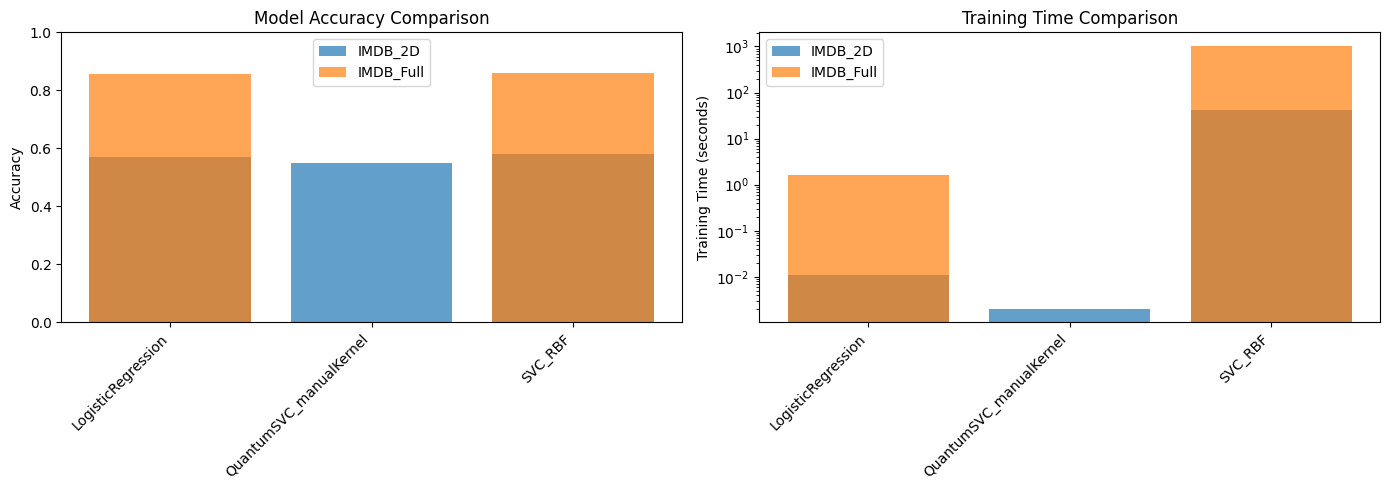

In [19]:
# Combine all results
classical_results_2d_df['dataset'] = 'IMDB_2D'
classical_results_full_df['dataset'] = 'IMDB_Full'
q_result_df['dataset'] = 'IMDB_2D'

# Add note about quantum sample size
full_results_df = pd.concat([
    classical_results_full_df,
    classical_results_2d_df,
    q_result_df
], ignore_index=True)

full_results_df = full_results_df.sort_values(by=["dataset", "model"]).reset_index(drop=True)
print("\nAll Results Comparison:")
print(full_results_df)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
ax1 = axes[0]
for dataset in full_results_df['dataset'].unique():
    subset = full_results_df[full_results_df['dataset'] == dataset]
    ax1.bar(subset['model'], subset['accuracy'], alpha=0.7, label=dataset)
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison')
ax1.legend()
ax1.set_ylim([0, 1])
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Training time comparison
ax2 = axes[1]
for dataset in full_results_df['dataset'].unique():
    subset = full_results_df[full_results_df['dataset'] == dataset]
    ax2.bar(subset['model'], subset['train_time_sec'], alpha=0.7, label=dataset)
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('Training Time Comparison')
ax2.legend()
ax2.set_yscale('log')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


# Summary and Discussion

This notebook compares classical and quantum machine learning models on the IMDB movie review dataset:

1. **Data Preprocessing**: The IMDB dataset is loaded and converted to TF-IDF features, then reduced to 2D using PCA for quantum compatibility.

2. **Classical Models**:
   - Logistic Regression
   - SVC with RBF kernel
   - Tested on both full-dimensional and 2D reduced data

3. **Quantum Model**:
   - Quantum SVC using ZZFeatureMap with 2 qubits
   - Tested on 2D reduced data with a small subset (40 train, 20 test) due to computational constraints

**Key Observations**:
- Dimensionality reduction significantly impacts model performance
- Quantum models require small datasets due to exponential scaling of kernel computation
- Classical models on full-dimensional data typically outperform reduced-dimensional and quantum approaches
- Training time for quantum models is much longer due to kernel matrix computation
